In [1]:
from PIL import Image

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from __future__ import division, print_function
import sys

In [2]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    

torch.Size([200, 1]) torch.Size([200, 3])
torch.Size([10, 1]) torch.Size([10, 3])


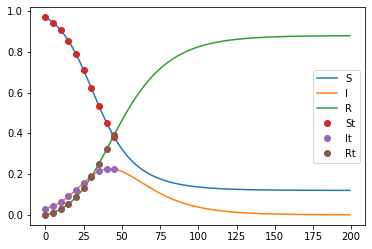

In [3]:
sim = pd.read_csv('./sim_SIR.csv')
N_old = sim['S'][0] + sim['I'][0] + sim['R'][0]
sim['S'] = sim['S'] / N_old
sim['I'] = sim['I'] / N_old
sim['R'] = sim['R'] / N_old

sim_t = torch.tensor(sim[['t']].values, dtype=torch.float32)
sim_data = torch.tensor(sim[['S', 'I', 'R']].values, dtype=torch.float32)

print(sim_t.shape, sim_data.shape)

sim_t_train = sim_t[:50:5]
sim_data_train = sim_data[:50:5]

print(sim_t_train.shape, sim_data_train.shape)

fig = plt.figure()
plt.plot(sim_t, sim_data, label=['S', 'I', 'R'])
plt.plot(sim_t_train, sim_data_train, 'o', label=['St', 'It', 'Rt'])
plt.legend();

In [4]:
def plot_result(i,x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(15,7))
    
    plt.plot(x,yh[:, 0], color="tab:red", linewidth=2, alpha=0.8, label="NN S")
    plt.plot(x,yh[:, 1], color="tab:green", linewidth=2, alpha=0.8, label="NN I")
    plt.plot(x,yh[:, 2], color="tab:blue", linewidth=2, alpha=0.8, label="NN R")
    plt.plot(x,y[:, 0], color="red", linewidth=2, alpha=0.8,linestyle='--',label="Exact S")
    plt.plot(x,y[:, 1], color="green", linewidth=2, alpha=0.8,linestyle='--',label="Exact I")
    plt.plot(x,y[:, 2], color="blue", linewidth=2, alpha=0.8,linestyle='--',label="Exact R")
    plt.scatter(x_data, y_data[:, 0], s=60, color="tab:red", alpha=0.4, label='Training S')
    plt.scatter(x_data, y_data[:, 1], s=60, color="tab:green", alpha=0.4, label='Training I')
    plt.scatter(x_data, y_data[:, 2], s=60, color="tab:blue", alpha=0.4, label='Training R')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Colloc. points')
    """l = plt.legend(loc=(0.701,0.14), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.text(1.665,1.3,"Step: %i"%(i+1),fontsize="xx-large",color="k")"""
    plt.title('SIR model, step %i'%(i+1),fontsize="xx-large")
    plt.ylabel('SIR',fontsize="xx-large")
    plt.xlabel('Time',fontsize="xx-large")
    plt.legend()
    plt.axis("on")
    plt.show()


1000 2.082641458400758e-06
2000 0.0001104842740460299
3000 1.575122610120161e-06
4000 3.5584307624958456e-05
5000 8.087192691164091e-05


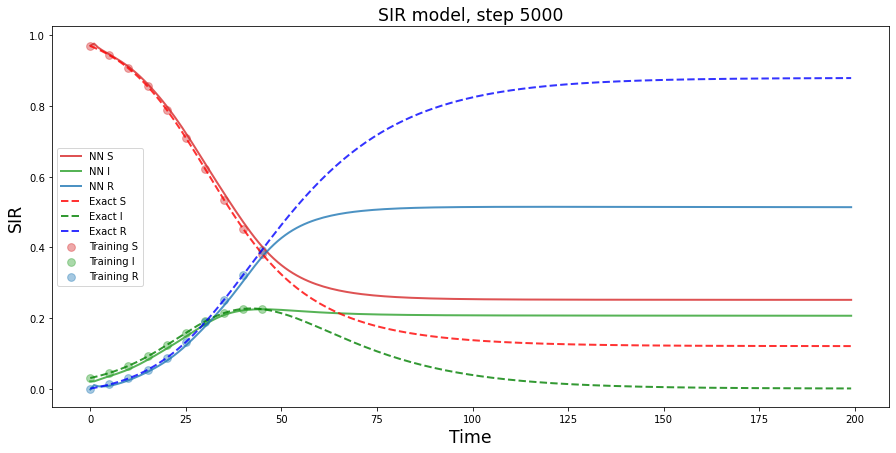

6000 3.1179877169051906e-06
7000 0.00012464335304684937
8000 2.0567553292494267e-05
9000 2.5492471422694507e-07
10000 3.8415257108681544e-07


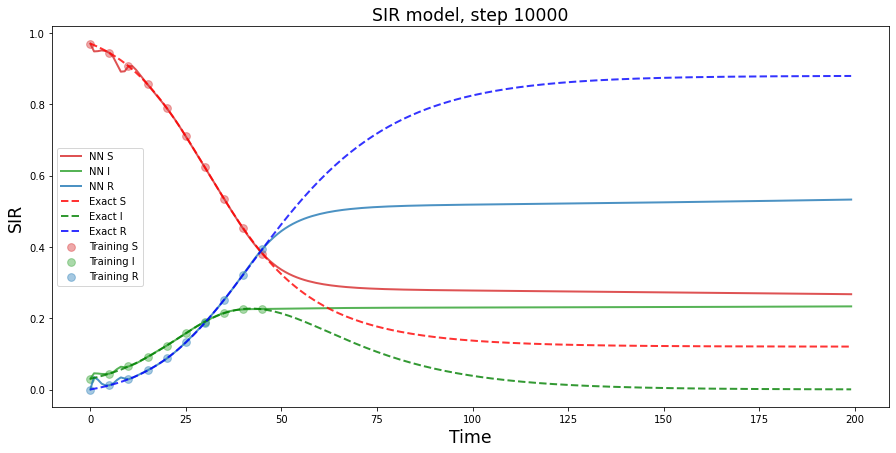

11000 1.1563645784917753e-05
12000 9.325870450993534e-06
13000 0.00032683712197467685
14000 1.952603042809642e-06
15000 3.948680671328475e-07


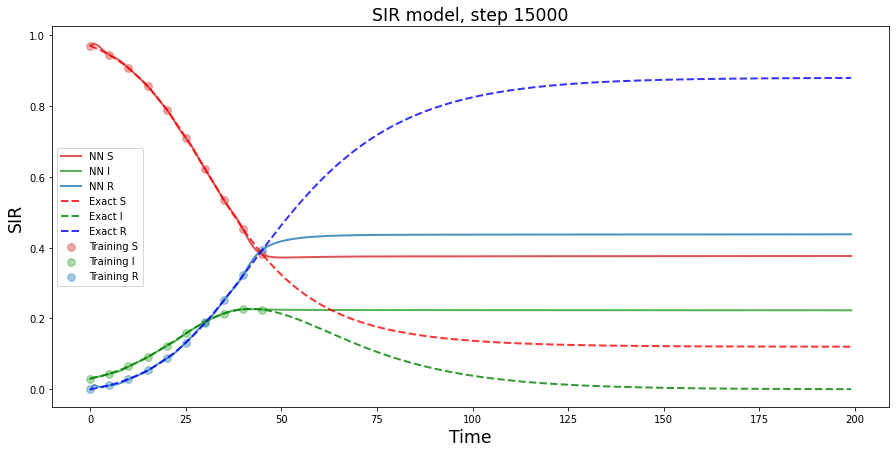

In [5]:
x_data = sim_t_train
y_data = sim_data_train
x = sim_t
y = sim_data

# We train a standard neural network to fit training data (one must choos lr and number of
# layers, number of neurons per layer) ....................................................
torch.manual_seed(127)
model = FCN(1,3,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
files = []
for i in range(15000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error to define Loss on data ......
    loss.backward()
    optimizer.step()
        
    # plot the result as training progresses ..............................................
    if (i+1) % 1000 == 0: print(i+1,loss.item())
    if (i+1) % 100 == 0:         
        yh = model(x).detach()       
        #plot_result(i,x,y,x_data,y_data,yh)   
        if (i+1) % 5000 == 0: plot_result(i,x,y,x_data,y_data,yh) 
        else: plt.close("all")
            

500 tensor(2.0201e-05) tensor(2.8044e-05) tensor(4.8245e-05) tensor(0.0082, grad_fn=<MeanBackward0>)
1000 tensor(3.2929e-06) tensor(1.4715e-05) tensor(1.8008e-05) tensor(0.0031, grad_fn=<MeanBackward0>)
1500 tensor(1.9877e-06) tensor(1.0160e-05) tensor(1.2148e-05) tensor(0.0017, grad_fn=<MeanBackward0>)
2000 tensor(1.3341e-06) tensor(7.8332e-06) tensor(9.1673e-06) tensor(0.0013, grad_fn=<MeanBackward0>)
2500 tensor(7.1067e-05) tensor(1.3176e-05) tensor(8.4243e-05) tensor(0.0020, grad_fn=<MeanBackward0>)
3000 tensor(7.0424e-07) tensor(6.2547e-06) tensor(6.9589e-06) tensor(0.0006, grad_fn=<MeanBackward0>)
3500 tensor(5.9126e-07) tensor(6.0606e-06) tensor(6.6519e-06) tensor(0.0007, grad_fn=<MeanBackward0>)
4000 tensor(2.6377e-06) tensor(6.2190e-06) tensor(8.8567e-06) tensor(0.0014, grad_fn=<MeanBackward0>)
4500 tensor(5.6868e-07) tensor(5.8632e-06) tensor(6.4319e-06) tensor(0.0010, grad_fn=<MeanBackward0>)


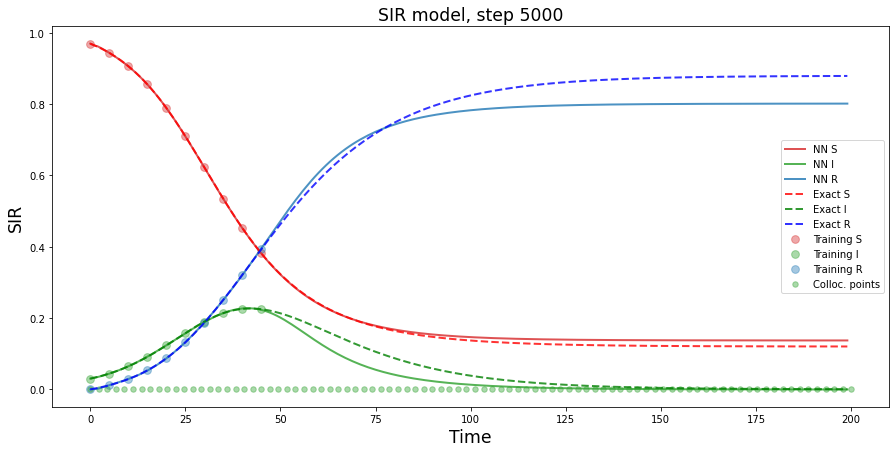

5000 tensor(5.8216e-07) tensor(5.7988e-06) tensor(6.3809e-06) tensor(0.0010, grad_fn=<MeanBackward0>)
5500 tensor(6.1311e-07) tensor(5.8232e-06) tensor(6.4363e-06) tensor(0.0013, grad_fn=<MeanBackward0>)
6000 tensor(5.1162e-07) tensor(5.8272e-06) tensor(6.3389e-06) tensor(0.0015, grad_fn=<MeanBackward0>)
6500 tensor(1.0584e-05) tensor(5.5478e-06) tensor(1.6132e-05) tensor(0.0022, grad_fn=<MeanBackward0>)
7000 tensor(6.7370e-07) tensor(5.7014e-06) tensor(6.3751e-06) tensor(0.0018, grad_fn=<MeanBackward0>)
7500 tensor(4.1008e-07) tensor(5.8875e-06) tensor(6.2976e-06) tensor(0.0024, grad_fn=<MeanBackward0>)
8000 tensor(4.8140e-07) tensor(5.8418e-06) tensor(6.3232e-06) tensor(0.0020, grad_fn=<MeanBackward0>)
8500 tensor(3.4934e-07) tensor(5.7933e-06) tensor(6.1426e-06) tensor(0.0018, grad_fn=<MeanBackward0>)
9000 tensor(5.1520e-07) tensor(5.7778e-06) tensor(6.2930e-06) tensor(0.0021, grad_fn=<MeanBackward0>)
9500 tensor(3.3295e-07) tensor(5.7376e-06) tensor(6.0706e-06) tensor(0.0017, grad_

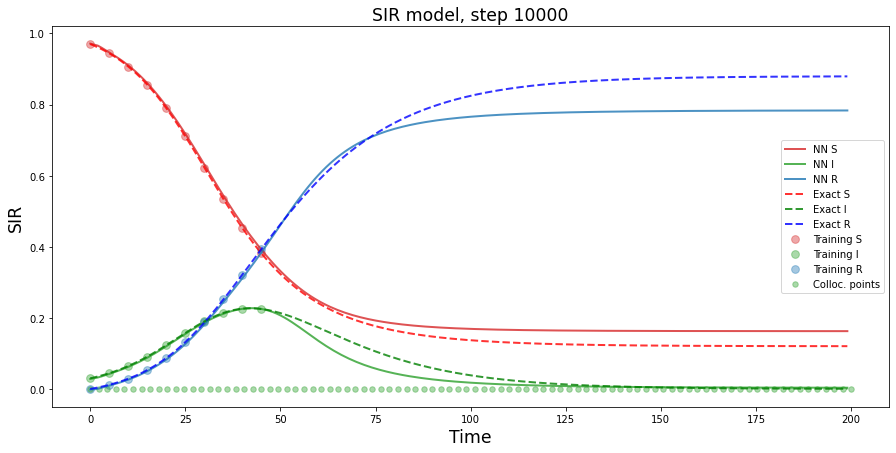

10000 tensor(2.3174e-05) tensor(5.5335e-06) tensor(2.8707e-05) tensor(0.0018, grad_fn=<MeanBackward0>)
10500 tensor(2.8050e-07) tensor(5.7471e-06) tensor(6.0276e-06) tensor(0.0018, grad_fn=<MeanBackward0>)
11000 tensor(2.4049e-06) tensor(5.4081e-06) tensor(7.8130e-06) tensor(0.0018, grad_fn=<MeanBackward0>)
11500 tensor(3.8506e-07) tensor(5.6691e-06) tensor(6.0541e-06) tensor(0.0013, grad_fn=<MeanBackward0>)
12000 tensor(0.0003) tensor(5.6963e-05) tensor(0.0004) tensor(0.0043, grad_fn=<MeanBackward0>)
12500 tensor(2.1628e-07) tensor(5.7451e-06) tensor(5.9614e-06) tensor(0.0016, grad_fn=<MeanBackward0>)
13000 tensor(2.1637e-07) tensor(5.6751e-06) tensor(5.8914e-06) tensor(0.0012, grad_fn=<MeanBackward0>)
13500 tensor(2.1904e-07) tensor(5.6525e-06) tensor(5.8715e-06) tensor(0.0013, grad_fn=<MeanBackward0>)
14000 tensor(1.5647e-06) tensor(5.6251e-06) tensor(7.1898e-06) tensor(0.0015, grad_fn=<MeanBackward0>)
14500 tensor(4.7417e-07) tensor(5.6351e-06) tensor(6.1093e-06) tensor(0.0014, gra

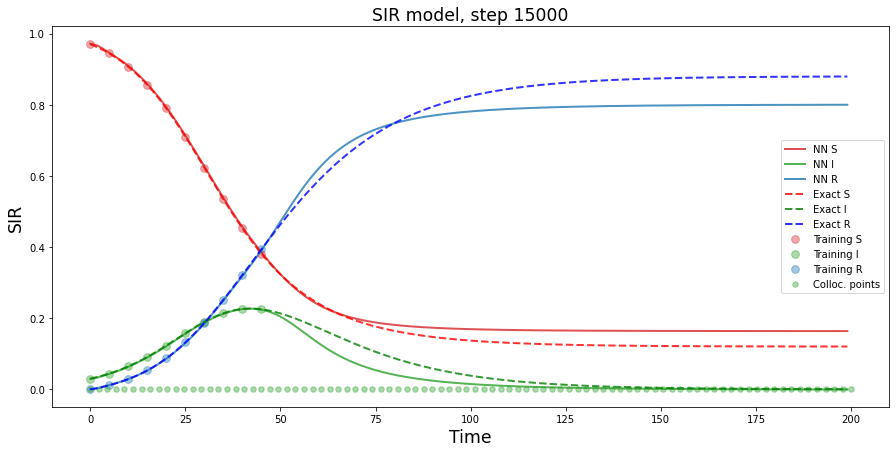

15000 tensor(6.4338e-06) tensor(5.4674e-06) tensor(1.1901e-05) tensor(0.0014, grad_fn=<MeanBackward0>)
15500 tensor(6.4115e-06) tensor(5.6216e-06) tensor(1.2033e-05) tensor(0.0012, grad_fn=<MeanBackward0>)
16000 tensor(2.4198e-06) tensor(5.7887e-06) tensor(8.2086e-06) tensor(0.0012, grad_fn=<MeanBackward0>)
16500 tensor(5.6569e-07) tensor(5.9478e-06) tensor(6.5135e-06) tensor(0.0018, grad_fn=<MeanBackward0>)
17000 tensor(3.9139e-07) tensor(5.5811e-06) tensor(5.9725e-06) tensor(0.0010, grad_fn=<MeanBackward0>)
17500 tensor(3.4862e-07) tensor(5.5726e-06) tensor(5.9213e-06) tensor(0.0010, grad_fn=<MeanBackward0>)
18000 tensor(4.9852e-07) tensor(5.5294e-06) tensor(6.0280e-06) tensor(0.0016, grad_fn=<MeanBackward0>)
18500 tensor(1.2280e-06) tensor(5.4795e-06) tensor(6.7074e-06) tensor(0.0015, grad_fn=<MeanBackward0>)
19000 tensor(4.0476e-07) tensor(5.5202e-06) tensor(5.9250e-06) tensor(0.0011, grad_fn=<MeanBackward0>)
19500 tensor(7.1326e-07) tensor(5.2787e-06) tensor(5.9919e-06) tensor(0.0

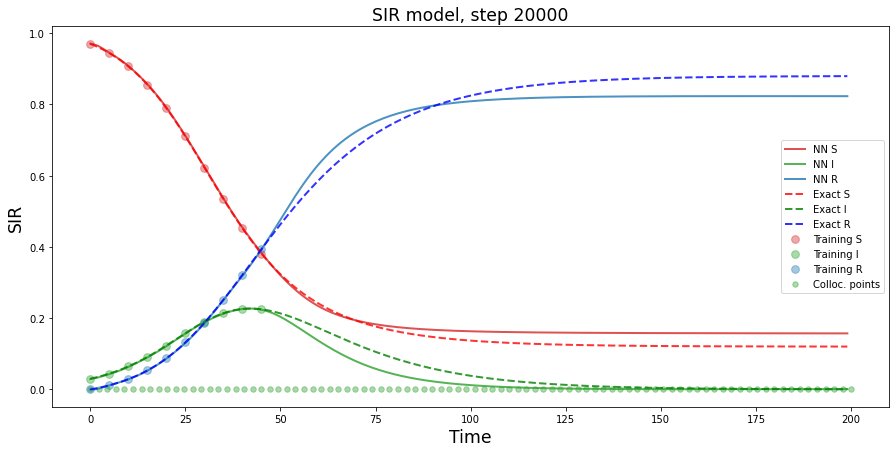

20000 tensor(1.2743e-06) tensor(5.4941e-06) tensor(6.7683e-06) tensor(0.0008, grad_fn=<MeanBackward0>)
20500 tensor(4.1757e-07) tensor(5.5438e-06) tensor(5.9613e-06) tensor(0.0010, grad_fn=<MeanBackward0>)
21000 tensor(5.2583e-07) tensor(5.4027e-06) tensor(5.9285e-06) tensor(0.0009, grad_fn=<MeanBackward0>)
21500 tensor(1.9532e-05) tensor(5.7277e-06) tensor(2.5260e-05) tensor(0.0012, grad_fn=<MeanBackward0>)
22000 tensor(2.6306e-07) tensor(5.3996e-06) tensor(5.6626e-06) tensor(0.0009, grad_fn=<MeanBackward0>)
22500 tensor(1.0166e-05) tensor(5.4027e-06) tensor(1.5568e-05) tensor(0.0009, grad_fn=<MeanBackward0>)
23000 tensor(9.9411e-06) tensor(8.9160e-06) tensor(1.8857e-05) tensor(0.0056, grad_fn=<MeanBackward0>)
23500 tensor(3.8254e-07) tensor(5.8666e-06) tensor(6.2492e-06) tensor(0.0019, grad_fn=<MeanBackward0>)
24000 tensor(2.6585e-07) tensor(5.5660e-06) tensor(5.8318e-06) tensor(0.0011, grad_fn=<MeanBackward0>)
24500 tensor(2.2592e-07) tensor(5.4683e-06) tensor(5.6942e-06) tensor(0.0

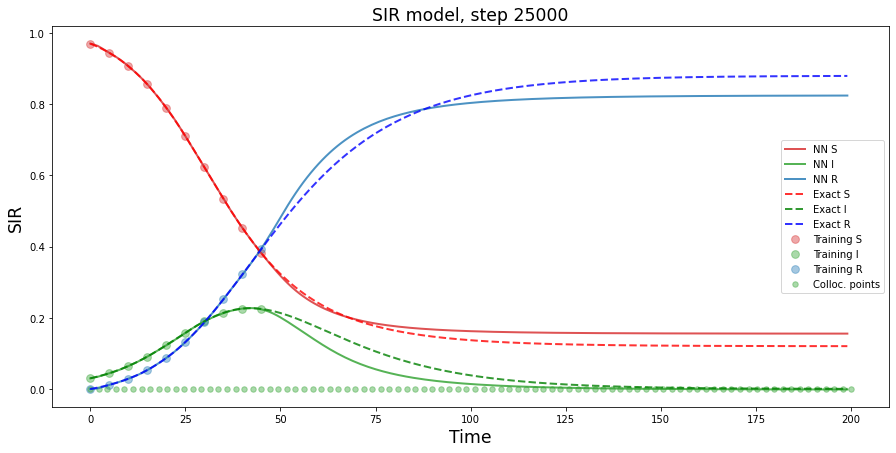

25000 tensor(1.8838e-07) tensor(5.4055e-06) tensor(5.5939e-06) tensor(0.0008, grad_fn=<MeanBackward0>)
25500 tensor(1.8304e-07) tensor(5.3794e-06) tensor(5.5624e-06) tensor(0.0008, grad_fn=<MeanBackward0>)
26000 tensor(2.7261e-07) tensor(5.3749e-06) tensor(5.6475e-06) tensor(0.0007, grad_fn=<MeanBackward0>)
26500 tensor(1.5279e-07) tensor(5.3370e-06) tensor(5.4898e-06) tensor(0.0006, grad_fn=<MeanBackward0>)
27000 tensor(1.3581e-07) tensor(5.3277e-06) tensor(5.4635e-06) tensor(0.0006, grad_fn=<MeanBackward0>)
27500 tensor(1.2540e-07) tensor(5.3309e-06) tensor(5.4563e-06) tensor(0.0006, grad_fn=<MeanBackward0>)
28000 tensor(1.2486e-05) tensor(5.3547e-06) tensor(1.7841e-05) tensor(0.0007, grad_fn=<MeanBackward0>)
28500 tensor(1.4488e-06) tensor(5.1597e-06) tensor(6.6085e-06) tensor(0.0005, grad_fn=<MeanBackward0>)
29000 tensor(3.3296e-06) tensor(5.1878e-06) tensor(8.5174e-06) tensor(0.0005, grad_fn=<MeanBackward0>)
29500 tensor(9.0907e-07) tensor(5.3319e-06) tensor(6.2409e-06) tensor(0.0

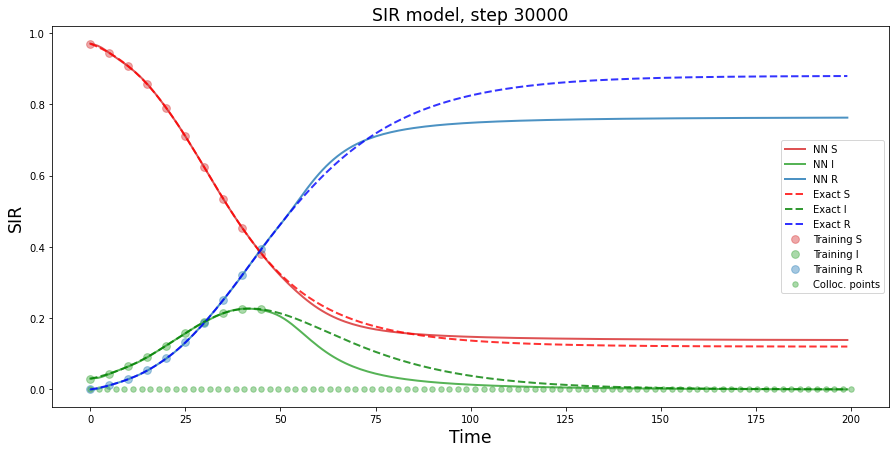

30000 tensor(4.8453e-07) tensor(7.0678e-06) tensor(7.5523e-06) tensor(0.0024, grad_fn=<MeanBackward0>)
30500 tensor(2.0495e-07) tensor(5.8790e-06) tensor(6.0839e-06) tensor(0.0020, grad_fn=<MeanBackward0>)
31000 tensor(1.8334e-07) tensor(5.6068e-06) tensor(5.7902e-06) tensor(0.0015, grad_fn=<MeanBackward0>)
31500 tensor(2.0090e-07) tensor(5.5332e-06) tensor(5.7341e-06) tensor(0.0012, grad_fn=<MeanBackward0>)
32000 tensor(3.2869e-07) tensor(5.4900e-06) tensor(5.8187e-06) tensor(0.0011, grad_fn=<MeanBackward0>)
32500 tensor(1.3422e-07) tensor(5.4399e-06) tensor(5.5741e-06) tensor(0.0010, grad_fn=<MeanBackward0>)
33000 tensor(1.2136e-07) tensor(5.3893e-06) tensor(5.5106e-06) tensor(0.0007, grad_fn=<MeanBackward0>)
33500 tensor(1.1785e-07) tensor(5.3751e-06) tensor(5.4930e-06) tensor(0.0007, grad_fn=<MeanBackward0>)
34000 tensor(3.2741e-06) tensor(5.1400e-06) tensor(8.4141e-06) tensor(0.0006, grad_fn=<MeanBackward0>)
34500 tensor(8.3117e-07) tensor(5.3191e-06) tensor(6.1503e-06) tensor(0.0

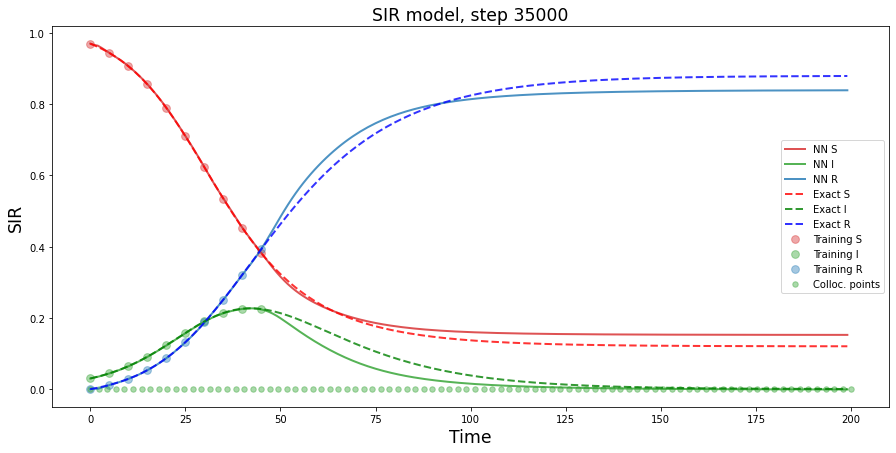

35000 tensor(3.2790e-07) tensor(5.3748e-06) tensor(5.7027e-06) tensor(0.0006, grad_fn=<MeanBackward0>)
35500 tensor(1.0577e-05) tensor(5.6672e-06) tensor(1.6245e-05) tensor(0.0005, grad_fn=<MeanBackward0>)
36000 tensor(1.4951e-05) tensor(5.5817e-06) tensor(2.0532e-05) tensor(0.0006, grad_fn=<MeanBackward0>)
36500 tensor(5.7887e-06) tensor(4.7691e-06) tensor(1.0558e-05) tensor(0.0006, grad_fn=<MeanBackward0>)
37000 tensor(8.7526e-07) tensor(5.4149e-06) tensor(6.2901e-06) tensor(0.0005, grad_fn=<MeanBackward0>)
37500 tensor(1.7614e-06) tensor(5.2433e-06) tensor(7.0047e-06) tensor(0.0005, grad_fn=<MeanBackward0>)
38000 tensor(3.8102e-07) tensor(5.4126e-06) tensor(5.7936e-06) tensor(0.0005, grad_fn=<MeanBackward0>)
38500 tensor(1.1114e-06) tensor(5.5067e-06) tensor(6.6181e-06) tensor(0.0005, grad_fn=<MeanBackward0>)
39000 tensor(4.8198e-06) tensor(5.0467e-06) tensor(9.8665e-06) tensor(0.0005, grad_fn=<MeanBackward0>)
39500 tensor(0.0005) tensor(0.0004) tensor(0.0009) tensor(0.0514, grad_fn

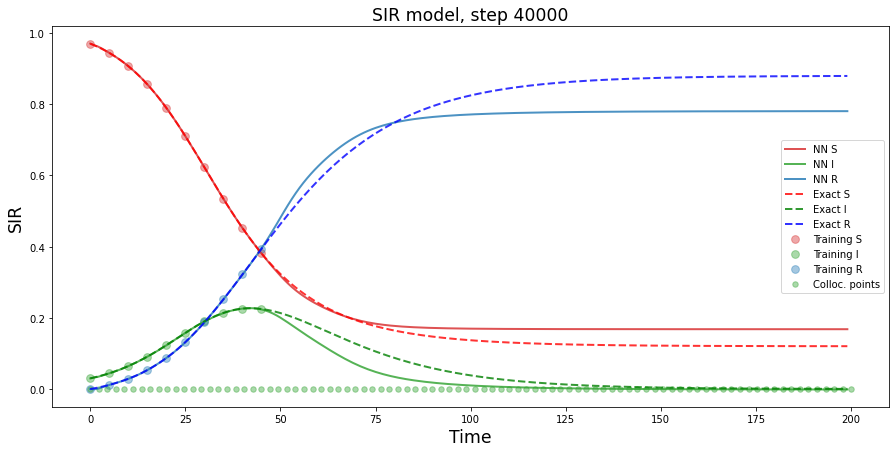

40000 tensor(1.9106e-07) tensor(5.5547e-06) tensor(5.7457e-06) tensor(0.0020, grad_fn=<MeanBackward0>)
40500 tensor(4.0025e-05) tensor(5.2876e-06) tensor(4.5313e-05) tensor(0.0020, grad_fn=<MeanBackward0>)
41000 tensor(1.3534e-07) tensor(5.4041e-06) tensor(5.5395e-06) tensor(0.0013, grad_fn=<MeanBackward0>)
41500 tensor(1.2408e-07) tensor(5.3716e-06) tensor(5.4957e-06) tensor(0.0011, grad_fn=<MeanBackward0>)
42000 tensor(6.0588e-07) tensor(5.4322e-06) tensor(6.0381e-06) tensor(0.0011, grad_fn=<MeanBackward0>)
42500 tensor(3.6750e-07) tensor(5.4008e-06) tensor(5.7683e-06) tensor(0.0013, grad_fn=<MeanBackward0>)
43000 tensor(3.8630e-07) tensor(5.3956e-06) tensor(5.7819e-06) tensor(0.0014, grad_fn=<MeanBackward0>)
43500 tensor(1.5922e-06) tensor(5.1181e-06) tensor(6.7103e-06) tensor(0.0011, grad_fn=<MeanBackward0>)
44000 tensor(1.3653e-06) tensor(5.6124e-06) tensor(6.9777e-06) tensor(0.0016, grad_fn=<MeanBackward0>)
44500 tensor(3.8761e-06) tensor(5.4426e-06) tensor(9.3187e-06) tensor(0.0

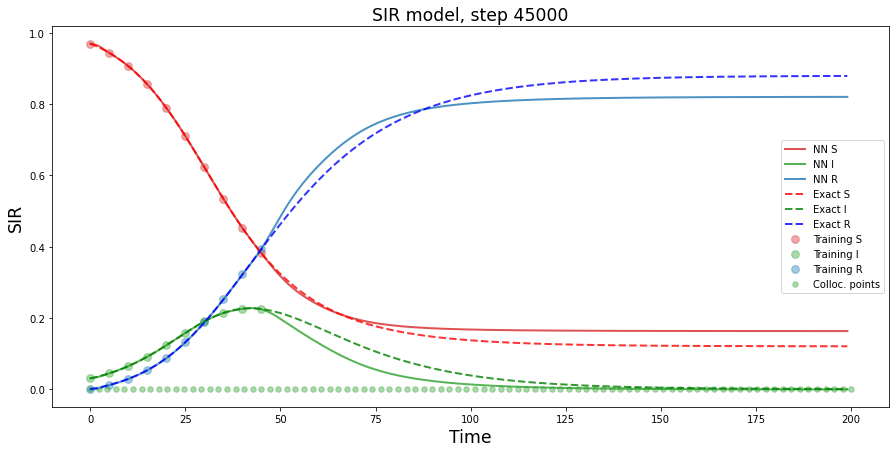

45000 tensor(2.3735e-07) tensor(5.2658e-06) tensor(5.5031e-06) tensor(0.0010, grad_fn=<MeanBackward0>)
45500 tensor(7.6070e-07) tensor(5.1196e-06) tensor(5.8803e-06) tensor(0.0009, grad_fn=<MeanBackward0>)
46000 tensor(2.0273e-07) tensor(5.4015e-06) tensor(5.6042e-06) tensor(0.0012, grad_fn=<MeanBackward0>)
46500 tensor(1.1613e-06) tensor(5.3092e-06) tensor(6.4705e-06) tensor(0.0009, grad_fn=<MeanBackward0>)
47000 tensor(1.7882e-06) tensor(5.5784e-06) tensor(7.3665e-06) tensor(0.0009, grad_fn=<MeanBackward0>)
47500 tensor(3.8146e-06) tensor(5.4491e-06) tensor(9.2638e-06) tensor(0.0031, grad_fn=<MeanBackward0>)
48000 tensor(9.0847e-08) tensor(5.3820e-06) tensor(5.4729e-06) tensor(0.0011, grad_fn=<MeanBackward0>)
48500 tensor(1.5958e-06) tensor(5.1522e-06) tensor(6.7480e-06) tensor(0.0011, grad_fn=<MeanBackward0>)
49000 tensor(8.0947e-06) tensor(5.0962e-06) tensor(1.3191e-05) tensor(0.0008, grad_fn=<MeanBackward0>)
49500 tensor(6.2635e-06) tensor(5.1338e-06) tensor(1.1397e-05) tensor(0.0

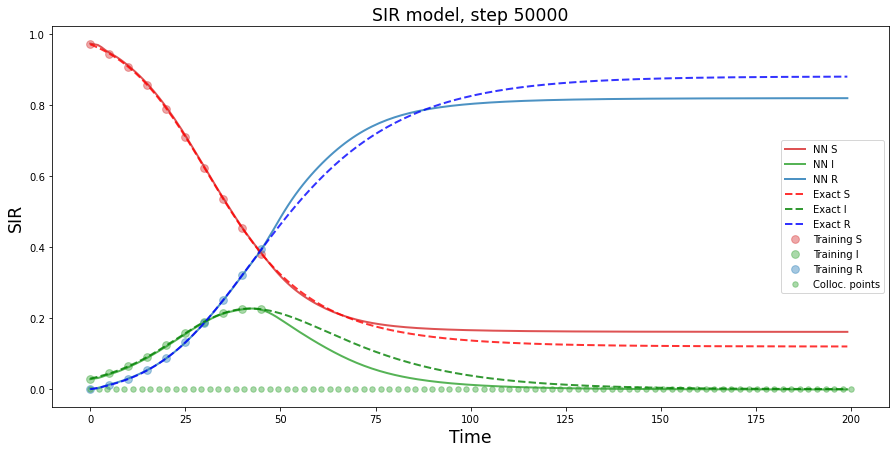

50000 tensor(4.1502e-06) tensor(5.5378e-06) tensor(9.6880e-06) tensor(0.0010, grad_fn=<MeanBackward0>)


In [18]:
# ......................
ww=1.0
N = 1.0
beta = 0.177
gamma = 0.089
torch.manual_seed(123)
model = FCN(1,3,42,4)

optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []
loss1_history = []
loss2_history = []
loss_history = []
mse_history = []

x_physics = torch.linspace(0.,200,90).view(-1,1).requires_grad_(True)

for i in range(50000):
    #lim= np.minimum(200*i/74000.,200)
    #x_physics = torch.linspace(0.,lim,90).view(-1,1).requires_grad_(True)#
    optimizer.zero_grad()
    
    # compute the "data loss" ..................................................
    yh = model(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)
    
    # compute the "physics loss" with enforcing the initial data ..............
    yhp = model(x_physics)
    yhp1= yhp[:,0].view(-1,1)
    yhp2= yhp[:,1].view(-1,1) 
    yhp3= yhp[:,2].view(-1,1)
    
    # compute first and second derivatives by automatic differentiation ....................
    dx1 = torch.autograd.grad(yhp1, x_physics, torch.ones_like(yhp1), create_graph=True)[0]
    dx2 = torch.autograd.grad(yhp2, x_physics, torch.ones_like(yhp2), create_graph=True)[0]
    dx3 = torch.autograd.grad(yhp3, x_physics, torch.ones_like(yhp3), create_graph=True)[0]
    #! aqui quede
    # computes the residual .............................................
    physics2 = (dx1 + beta/N*yhp1*yhp2)                
    physics1 = (dx2 - beta/N*yhp1*yhp2 + gamma*yhp2)
    physics3 = (dx3 - gamma*yhp2)
    loss2 = 1*torch.mean((physics1)**2) + 1*torch.mean((physics2)**2) + 1*torch.mean((physics3)**2)
    
    # backpropagate the total loss ...............................................
    loss = loss1 + loss2  # add two loss terms together .....................
    loss.backward()
    optimizer.step()    
        
    # plot the result as training progresses ...............................
    
    if (i+1) % 500 == 0: 
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss_history.append(loss.detach())
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        yhpp=model(x)
        mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution .....
        mse_history.append(mse.detach())

        if (i+1) % 500 == 0 and (i+1) < 5000: plot_result(i,x,y,x_data,y_data,yh,xp)
        if (i+1) % 5000 == 0: plot_result(i,x,y,x_data,y_data,yh,xp)
        else: plt.close("all")
    if (i+1) % 500 == 0: print(i+1, loss1.detach(), loss2.detach(), loss.detach(), mse)
    

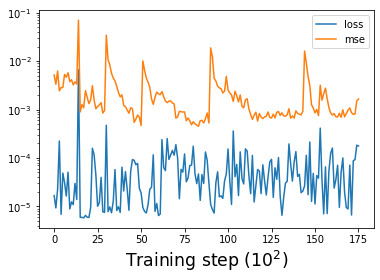

In [16]:
fig33 = plt.figure(33)
plt.plot(loss_history, label="loss")
plt.plot(mse_history, label="mse")
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.yscale('log')
plt.legend()

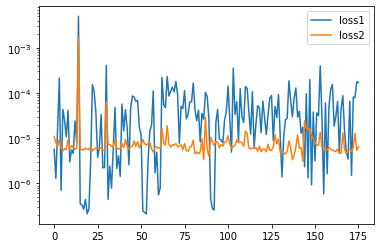

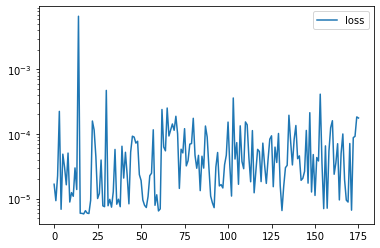

In [17]:
fig50 = plt.figure(50)
plt.plot(loss1_history, label="loss1")
plt.plot(loss2_history, label="loss2")
plt.yscale('log')
plt.legend()

fig51 = plt.figure(51)
plt.plot(loss_history, label="loss")
plt.yscale('log')
plt.legend()